In [ ]:
!pip install google-generativeai python-dotenv pillow pillow-heif

In [2]:
import os
import json
import google.generativeai as genai
from dotenv import load_dotenv
import PIL.Image
from datetime import datetime
from pillow_heif import register_heif_opener

# HEICファイルのサポートを有効化
register_heif_opener()

# .envファイルから環境変数を読み込む
load_dotenv()

/Users/ishidashouhei/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
# APIキーの設定
API_KEY = os.environ.get("GEMINI_API_KEY")
if not API_KEY:
    print("APIキーが設定されていません。'.env'ファイルを確認してください。")
    exit()

print("Gemini APIキーを読み込みました。")
genai.configure(api_key=API_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")

Gemini APIキーを読み込みました。


In [17]:
# 分類項目リスト
CLASSIFICATION_MAP = {
    "ハウススタジオ": ["和風", "洋風", "一軒家", "マンション", "アパート"],
    "公園": ["公園"],
    "オフィス": ["執務室", "会議室", "ロビー"],
    "商業施設": [
        "ショッピングモール",
        "遊園地",
        "水族館/動物園/植物園",
        "博物館/美術館",
        "映画館",
        "ボーリング/ゲームセンター/ビリヤード",
        "商店街",
    ],
    "学校": ["小学校", "中学校", "高校", "大学/専門学校", "幼稚園/保育園"],
    "病院": ["受付", "手術室"],
    "店舗": ["コンビニ", "ドラッグストア", "スーパー", "アパレル", "ガソリンスタンド"],
    "飲食店": ["中華料理屋", "レストラン", "カフェ", "居酒屋", "食堂", "BAR"],
    "自然": ["山", "川", "海", "草原", "森", "湖/池", "花畑", "道"],
    "その他": [
        "駐車場",
        "屋上",
        "神社仏閣",
        "オープンスペース",
        "夜景/イルミネーション",
    ],
}

IMPRESSION_TAGS = {
  "ムード/トーン": [
    {"label":"落ち着き","slug":"calm"},
    {"label":"温かみ","slug":"warm"},
    {"label":"クリーン","slug":"clean"},
    {"label":"クール","slug":"cool"},
    {"label":"高級感","slug":"luxury"},
    {"label":"無機質/インダストリアル","slug":"industrial"},
    {"label":"ナチュラル/オーガニック","slug":"natural"},
    {"label":"ノスタルジック/レトロ","slug":"nostalgic"},
    {"label":"非日常/シュール","slug":"surreal"},
    {"label":"荒廃/退廃","slug":"decayed"},
    {"label":"荘厳/重厚","slug":"majestic"},
    {"label":"生活感あり","slug":"lived_in"},
    {"label":"ミニマル","slug":"minimal"}
  ],
  "光の雰囲気": [
    {"label":"自然光豊富","slug":"abundant_daylight"},
    {"label":"柔らかい拡散光","slug":"soft_diffused"},
    {"label":"コントラスト強","slug":"high_contrast"},
    {"label":"低照度/ダーク","slug":"low_light"},
    {"label":"暖色照明","slug":"warm_lighting"},
    {"label":"寒色照明","slug":"cool_lighting"},
    {"label":"ネオン/サイン光","slug":"neon"},
    {"label":"逆光が活きる","slug":"backlight_friendly"}
  ],
  "色調/パレット": [
    {"label":"白基調","slug":"white_dominant"},
    {"label":"木色/アースカラー","slug":"earth_tones"},
    {"label":"コンクリ/グレー","slug":"concrete_gray"},
    {"label":"レンガ/レッド系","slug":"brick_red"},
    {"label":"モノクロ/デサチュレート","slug":"monochrome"},
    {"label":"パステル","slug":"pastel"},
    {"label":"ビビッド","slug":"vivid"}
  ],
  "素材感/質感": [
    {"label":"木質感","slug":"wood_texture"},
    {"label":"打ちっぱなし","slug":"exposed_concrete"},
    {"label":"金属/配管露出","slug":"exposed_metal_duct"},
    {"label":"タイル/石","slug":"tile_stone"},
    {"label":"ガラス多用","slug":"glass_heavy"},
    {"label":"漆喰/土壁","slug":"plaster_clay"},
    {"label":"畳/和素材","slug":"tatami_washi"},
    {"label":"ファブリック多め","slug":"fabric_rich"}
  ],
  "時代感/テイスト": [
    {"label":"現代的/モダン","slug":"modern"},
    {"label":"ミッドセンチュリー","slug":"midcentury"},
    {"label":"昭和レトロ","slug":"showa_retro"},
    {"label":"和モダン","slug":"japanese_modern"},
    {"label":"アールデコ/クラシック","slug":"art_deco_classic"},
    {"label":"インダストリアル","slug":"industrial_style"}
  ],
  "空間スケール/印象": [
    {"label":"大空間/吹き抜け","slug":"grand_void"},
    {"label":"天井高い","slug":"high_ceiling"},
    {"label":"コンパクト/狭小","slug":"compact"},
    {"label":"ロングコリドー","slug":"long_corridor"},
    {"label":"開放感","slug":"open_feel"},
    {"label":"密閉感","slug":"enclosed"}
  ]
}


OBJECT_TAGS = {
  "建築要素": [
    {"label":"屋根（陸屋根/切妻等）","slug":"roof_flat_gable"},
    {"label":"梁/柱が見える","slug":"exposed_beams_columns"},
    {"label":"吹き抜け","slug":"atrium_void"},
    {"label":"階段（直/螺旋/外階段）","slug":"stairs_straight_spiral_external"},
    {"label":"回廊/ピロティ","slug":"colonnade_piloti"},
    {"label":"ロフト","slug":"loft"},
    {"label":"中庭/坪庭","slug":"courtyard_tsuboniwa"},
    {"label":"縁側/土間","slug":"engawa_doma"},
    {"label":"露出配管/ダクト","slug":"exposed_ducts"},
    {"label":"大開口/全面ガラス","slug":"large_opening_glass"},
    {"label":"バルコニー/テラス","slug":"balcony_terrace"}
  ],
  "造作・設備": [
    {"label":"キッチン（アイランド/業務用）","slug":"kitchen_island_pro"},
    {"label":"カウンター/バー","slug":"counter_bar"},
    {"label":"暖炉/薪ストーブ","slug":"fireplace_stove"},
    {"label":"造作書棚/収納壁","slug":"built_in_shelves"},
    {"label":"バス/浴槽（在来/ユニット/露天）","slug":"bath_tub_types"},
    {"label":"シャワールーム","slug":"shower_room"},
    {"label":"洗面/トイレ","slug":"washroom_wc"},
    {"label":"サウナ","slug":"sauna"},
    {"label":"プール","slug":"pool"},
    {"label":"ジム器具","slug":"gym_equipment"},
    {"label":"エレベーター/貨物用","slug":"elevator_freight"},
    {"label":"エスカレーター","slug":"escalator"}
  ],
  "開口部/遮蔽": [
    {"label":"大窓/連窓","slug":"ribbon_windows"},
    {"label":"出窓/天窓","slug":"bay_skylight"},
    {"label":"引き戸/障子/格子","slug":"sliding_shoji_lattice"},
    {"label":"ガラス扉/防火扉","slug":"glass_fire_door"},
    {"label":"カーテン/レース","slug":"curtains"},
    {"label":"ブラインド/シャッター","slug":"blinds_shutter"}
  ],
  "照明": [
    {"label":"ペンダント/シャンデリア","slug":"pendant_chandelier"},
    {"label":"ダウンライト/埋込","slug":"downlights_recessed"},
    {"label":"ライティングレール","slug":"track_lighting"},
    {"label":"裸電球/エジソン","slug":"barebulb_edison"},
    {"label":"間接照明","slug":"indirect_lighting"},
    {"label":"ネオン/看板光","slug":"neon_signage"}
  ],
  "家具（室内）": [
    {"label":"ダイニングチェア","slug":"dining_chair"},
    {"label":"ラウンジチェア/アームチェア","slug":"lounge_arm_chair"},
    {"label":"スツール/バースツール","slug":"stool_barstool"},
    {"label":"ベンチ","slug":"bench"},
    {"label":"ダイニングテーブル","slug":"dining_table"},
    {"label":"ローテーブル/コーヒー","slug":"coffee_table"},
    {"label":"ソファ（レザー/ファブリック）","slug":"sofa_leather_fabric"},
    {"label":"カウチ/セクショナル","slug":"couch_sectional"},
    {"label":"デスク/ワークテーブル","slug":"desk_worktable"},
    {"label":"本棚/キャビネット","slug":"bookshelf_cabinet"},
    {"label":"ワードローブ/ラック","slug":"wardrobe_rack"},
    {"label":"パーティション","slug":"partition"},
    {"label":"ミラー/姿見","slug":"mirror"},
    {"label":"ラグ/絨毯","slug":"rug_carpet"},
    {"label":"ベッド","slug":"bed"}
  ],
  "小道具・装飾": [
    {"label":"観葉植物/ドライ/花","slug":"plants_flowers"},
    {"label":"アート/額装","slug":"art_frames"},
    {"label":"壁時計/置時計","slug":"clocks"},
    {"label":"オブジェ/彫刻","slug":"objects_sculpture"},
    {"label":"楽器（ピアノ/ギター等）","slug":"musical_instruments"},
    {"label":"書籍/雑誌","slug":"books_magazines"},
    {"label":"食器/グラス/ボトル","slug":"tableware_bottles"},
    {"label":"レコード/オーディオ","slug":"vinyl_audio"},
    {"label":"PC/モニター","slug":"pc_monitor"},
    {"label":"家電（冷蔵庫/電子レンジ等）","slug":"home_appliances"},
    {"label":"工具/作業台","slug":"tools_workbench"},
    {"label":"ホワイトボード/掲示板","slug":"whiteboard_bulletin"}
  ],
  "屋外要素": [
    {"label":"ウッドデッキ/芝/庭園","slug":"deck_lawn_garden"},
    {"label":"屋上/ヘリポート風","slug":"rooftop_helipad_like"},
    {"label":"ガレージ/シャッター/駐車場","slug":"garage_parking"},
    {"label":"道路/路地/階段屋外","slug":"street_alley_outstairs"},
    {"label":"橋/トンネル","slug":"bridge_tunnel"},
    {"label":"噴水/池/川/海/砂浜","slug":"water_features_beach"},
    {"label":"岩場/林/竹林","slug":"rocks_forest_bamboo"},
    {"label":"石垣/塀/門/鳥居","slug":"stone_wall_gate_torii"},
    {"label":"看板/サイン/自販機","slug":"signage_vending"}
  ]
}

In [24]:
def classify_property(folder_path, folder_name):
    """
    単一の物件フォルダ内の画像を分類する関数
    """
    # フォルダ内の画像ファイルを取得（.heicも追加）
    image_files = [
        f
        for f in os.listdir(folder_path)
        if f.lower().endswith(
            (".jpg", ".jpeg", ".png", ".gif", ".bmp", ".heic", ".heif", ".webp")
        )
    ]

    if not image_files:
        print(f"  ⚠️ {folder_name}に画像がありません")
        return None

    print(f"  📸 {len(image_files)}枚の画像を分析中...")

    # すべての画像を読み込み（最大10枚に制限）
    images = []
    for image_file in image_files[:10]:  # メモリとAPI制限を考慮
        image_path = os.path.join(folder_path, image_file)
        try:
            image = PIL.Image.open(image_path)

            # HEICの場合、RGBに変換（透明度チャンネルを除去）
            if image.mode in ("RGBA", "LA", "P"):
                # 白背景でRGBに変換
                rgb_image = PIL.Image.new("RGB", image.size, (255, 255, 255))
                if image.mode == "P":
                    image = image.convert("RGBA")
                rgb_image.paste(
                    image, mask=image.split()[-1] if image.mode == "RGBA" else None
                )
                image = rgb_image
            elif image.mode != "RGB":
                image = image.convert("RGB")

            # 画像サイズを適度に縮小（必要に応じて）
            max_size = (1024, 1024)
            image.thumbnail(max_size, PIL.Image.Resampling.LANCZOS)
            images.append(image)

        except Exception as e:
            print(f"    ⚠️ 画像読み込みエラー ({image_file}): {e}")
            # HEICファイルの場合、特別なエラーメッセージ
            if image_file.lower().endswith((".heic", ".heif")):
                print(
                    f"    💡 HEICファイルの読み込みに失敗しました。pillow-heifがインストールされているか確認してください。"
                )

    if not images:
        return None

    # プロンプト
    broad_categories = ", ".join(CLASSIFICATION_MAP.keys())
    specific_categories = ", ".join(sum(CLASSIFICATION_MAP.values(), []))
    impression_choices = ", ".join([
        f"{g}: " + ", ".join([f"{t['label']}({t['slug']})" for t in tags])
        for g, tags in IMPRESSION_TAGS.items()
        ])
    object_choices = ", ".join([
    f"{g}: " + ", ".join([f"{t['label']}({t['slug']})" for t in tags])
    for g, tags in OBJECT_TAGS.items()
    ])


    prompt = f"""
あなたは不動産・撮影スタジオの専門家です。
以下の{len(images)}枚の写真は、同一物件の様々な場所を撮影したものです。
これらの写真を総合的に分析し、この物件全体がどのような施設なのかを判定してください。

【重要な判定基準】
- 建物全体の用途と特徴
- 内装のスタイルと統一感
- 設備や家具から推測される使用目的
- 撮影スタジオとしての活用可能性

大分類の選択肢: {broad_categories}
小項目の選択肢: {specific_categories}
印象タグの選択肢（例: ラベル(スラッグ)）: {impression_choices}
オブジェクトタグの選択肢（例: ラベル(スラッグ)）: {object_choices}

JSON形式で以下のように簡潔に出力してください：
{{
    "大分類": "最も適切な大分類を1つ",
    "小項目": "最も適切な小項目を1つ",
    "印象タグ": ["上から重要順に最大5つ（スラッグで）"],
    "オブジェクトタグ": ["上から重要順に最大8つ（スラッグで）"],
    "判定理由": "なぜそう判断したか30文字以内で簡潔に"
}}
"""

    try:
        # Geminiに送信
        content_parts = [prompt] + images
        response = model.generate_content(
            content_parts, generation_config={"response_mime_type": "application/json"}
        )

        # 結果をパース
        result = json.loads(response.text)
        result["フォルダ名"] = folder_name
        result["画像枚数"] = len(image_files)

        return result

    except Exception as e:
        print(f"    ❌ 分析エラー: {e}")
        return {
            "フォルダ名": folder_name,
            "大分類": "エラー",
            "小項目": "エラー",
            "判定理由": str(e)[:30],
            "画像枚数": len(image_files),
        }



In [19]:
def main():
    """
    メイン処理：studio_photos内の各フォルダを処理
    """
    base_folder = "studio_photos"

    if not os.path.exists(base_folder):
        print(f"❌ {base_folder}フォルダが見つかりません")
        exit()

    # サブフォルダのリストを取得
    subfolders = [
        f
        for f in os.listdir(base_folder)
        if os.path.isdir(os.path.join(base_folder, f))
    ]

    if not subfolders:
        print(f"❌ {base_folder}内にサブフォルダがありません")
        print("物件ごとにフォルダを作成して画像を配置してください")
        exit()

    print(f"\n📂 {len(subfolders)}個の物件フォルダを発見")
    print("=" * 60)

    # 結果を保存するリスト
    all_results = []

    # 各フォルダを処理
    for i, folder_name in enumerate(sorted(subfolders), 1):
        print(f"\n[{i}/{len(subfolders)}] 処理中: {folder_name}")
        print("-" * 40)

        folder_path = os.path.join(base_folder, folder_name)
        result = classify_property(folder_path, folder_name)

        if result:
            all_results.append(result)
            print(f"  ✅ 大分類: {result['大分類']}")
            print(f"  📝 小項目: {result['小項目']}")
            print(f"  💡 理由: {result['判定理由']}")

    # 結果をCSV形式でも保存（Excelで開きやすい）
    if all_results:
        # JSON保存
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        json_file = f"classification_results_{timestamp}.json"
        with open(json_file, "w", encoding="utf-8") as f:
            json.dump(all_results, f, ensure_ascii=False, indent=2)

        # CSV保存
        csv_file = f"classification_results_{timestamp}.csv"
        with open(csv_file, "w", encoding="utf-8-sig") as f:  # BOM付きUTF-8
            f.write("フォルダ名,大分類,小項目,判定理由,画像枚数\n")
            for r in all_results:
                f.write(
                    f"{r['フォルダ名']},{r['大分類']},{r['小項目']},{r['判定理由']},{r.get('画像枚数', 0)}\n"
                )

        # 結果サマリーの表示
        print("\n" + "=" * 60)
        print("📊 分類結果サマリー")
        print("=" * 60)
        print(f"{'フォルダ名':<20} {'大分類':<10} {'小項目':<15} {'判定理由':<30}")
        print("-" * 80)
        for r in all_results:
            print(
                f"{r['フォルダ名']:<20} {r['大分類']:<10} {r['小項目']:<15} {r['判定理由']:<30}"
            )

        print("\n" + "=" * 60)
        print(f"✅ 処理完了: {len(all_results)}件の物件を分類しました")
        print(f"📄 結果ファイル:")
        print(f"   - JSON: {json_file}")
        print(f"   - CSV:  {csv_file}")

        # カテゴリ別集計
        category_count = {}
        for r in all_results:
            cat = r["大分類"]
            category_count[cat] = category_count.get(cat, 0) + 1

        print(f"\n📈 カテゴリ別集計:")
        for cat, count in sorted(category_count.items()):
            print(f"   - {cat}: {count}件")
    else:
        print("\n❌ 処理可能な物件がありませんでした")


In [11]:
# ノートブック表示用の追加インポート
import os, json, pandas as pd, PIL.Image
from IPython.display import display, JSON, Markdown
import matplotlib.pyplot as plt

# 画像ギャラリー（横グリッド）表示
def show_gallery(pil_images, title=None, cols=4, max_images=8):
    imgs = pil_images[:max_images]
    n = len(imgs)
    if n == 0:
        display(Markdown("**（表示できる画像がありません）**"))
        return
    rows = (n + cols - 1) // cols
    # 画像比率に依らず見やすいように1枚あたりサイズを調整
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, img in enumerate(imgs):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def pretty_json(obj, title=None):
    if title:
        display(Markdown(f"### {title}"))
    display(JSON(obj, expanded=True))

In [12]:
from datetime import datetime

def run_notebook_demo(base_folder="studio_photos", max_images_preview=8):
    """
    studio_photos配下の各物件フォルダを処理し、
    - 先に画像ギャラリー（縮小サムネ）
    - 次にGeminiの分類JSON
    - 最後に全体の表（DataFrame）
    をノートブック上に表示します。
    さらにJSON/CSVファイルも保存します。
    """
    if not os.path.exists(base_folder):
        display(Markdown(f"❌ **{base_folder} フォルダが見つかりません**"))
        return

    subfolders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
    if not subfolders:
        display(Markdown(f"❌ **{base_folder} 内にサブフォルダがありません**"))
        return

    all_results = []

    for i, folder_name in enumerate(sorted(subfolders), 1):
        display(Markdown(f"## [{i}/{len(subfolders)}] 物件フォルダ: `{folder_name}`"))
        folder_path = os.path.join(base_folder, folder_name)

        # 画像のプレビュー用に数枚読み込む（サムネ縮小）
        preview_images = []
        try:
            image_files = [
                f for f in os.listdir(folder_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp", ".heic", ".heif", ".webp"))
            ]
            for f in image_files[:max_images_preview]:
                p = os.path.join(folder_path, f)
                try:
                    im = PIL.Image.open(p)
                    if im.mode not in ("RGB", "RGBA"):
                        im = im.convert("RGB")
                    # 表示用は軽めに
                    im = im.copy()
                    im.thumbnail((768, 768), PIL.Image.Resampling.LANCZOS)
                    preview_images.append(im)
                except Exception as e:
                    print(f"⚠️ プレビュー用に {f} を読み込めませんでした: {e}")
        except Exception as e:
            print(f"⚠️ プレビュー画像の収集でエラー: {e}")

        # ギャラリー表示
        show_gallery(preview_images, title=f"{folder_name} - プレビュー", cols=4, max_images=max_images_preview)

        # 分類実行（あなたの関数を呼ぶ）
        result = classify_property(folder_path, folder_name)
        if result:
            all_results.append(result)
            # JSONを展開表示
            pretty_json(result, title="分類結果（JSON）")

    # 全体サマリーを表にして表示 & 保存
    if all_results:
        df = pd.DataFrame(all_results)
        display(Markdown("## 📊 全体サマリー（DataFrame）"))
        display(df)

        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        json_path = f"classification_results_{ts}.json"
        csv_path  = f"classification_results_{ts}.csv"

        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(all_results, f, ensure_ascii=False, indent=2)
        df.to_csv(csv_path, index=False, encoding="utf-8-sig")

        display(Markdown(f"**✅ 保存しました**  \n- JSON: `{json_path}`  \n- CSV: `{csv_path}`"))
    else:
        display(Markdown("❌ **処理可能な物件がありませんでした**"))

In [9]:
from IPython.display import display, JSON, Markdown

## [1/9] 物件フォルダ: `test_property_01`

/var/folders/c8/1r3mjsjs0gn4mpzb5k10b9hh0000gn/T/ipykernel_14044/1347505245.py:22: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from current font.
  plt.tight_layout()
/var/folders/c8/1r3mjsjs0gn4mpzb5k10b9hh0000gn/T/ipykernel_14044/1347505245.py:22: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from current font.
  plt.tight_layout()
/var/folders/c8/1r3mjsjs0gn4mpzb5k10b9hh0000gn/T/ipykernel_14044/1347505245.py:22: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from current font.
  plt.tight_layout()
/var/folders/c8/1r3mjsjs0gn4mpzb5k10b9hh0000gn/T/ipykernel_14044/1347505245.py:22: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from current font.
  plt.tight_layout()
/var/folders/c8/1r3mjsjs0gn4mpzb5k10b9hh0000gn/T/ipykernel_14044/1347505245.py:22: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  plt.tight_layout()
/Users/ishidashouhei/.pyenv/versions/3.10.11/lib/python3.10/site-pack

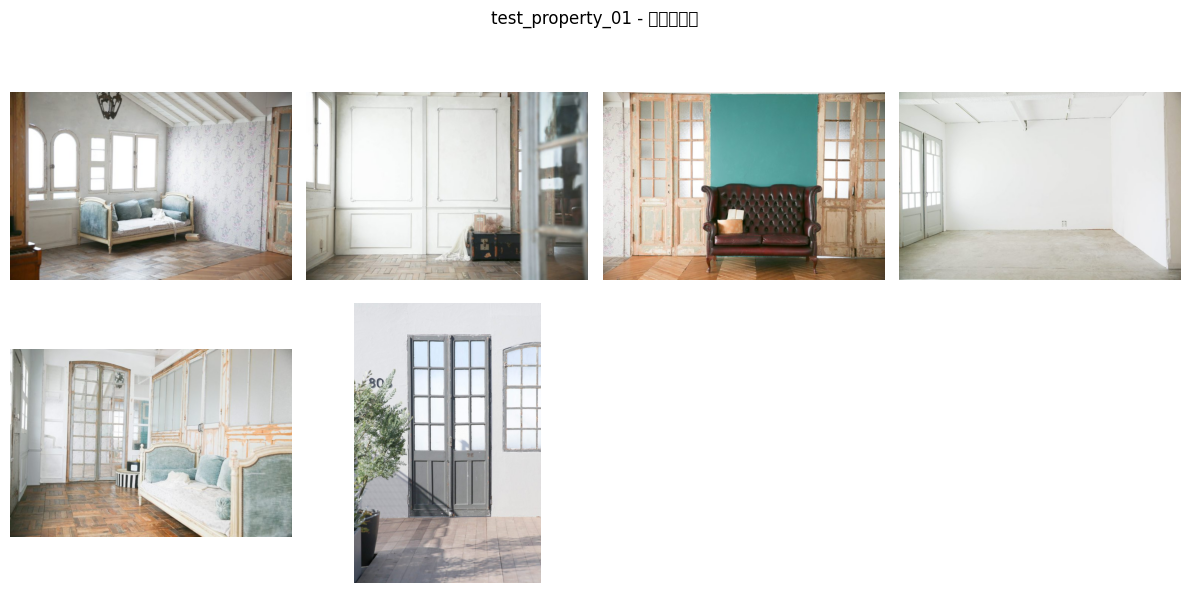

  📸 30枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [2/9] 物件フォルダ: `test_property_02`

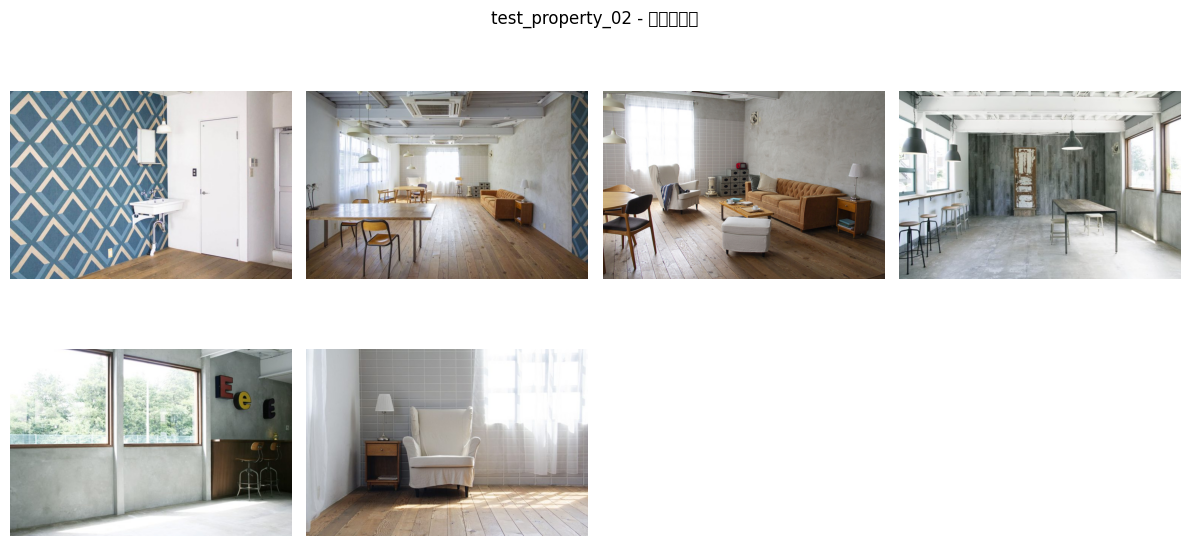

  📸 25枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [3/9] 物件フォルダ: `test_property_03`

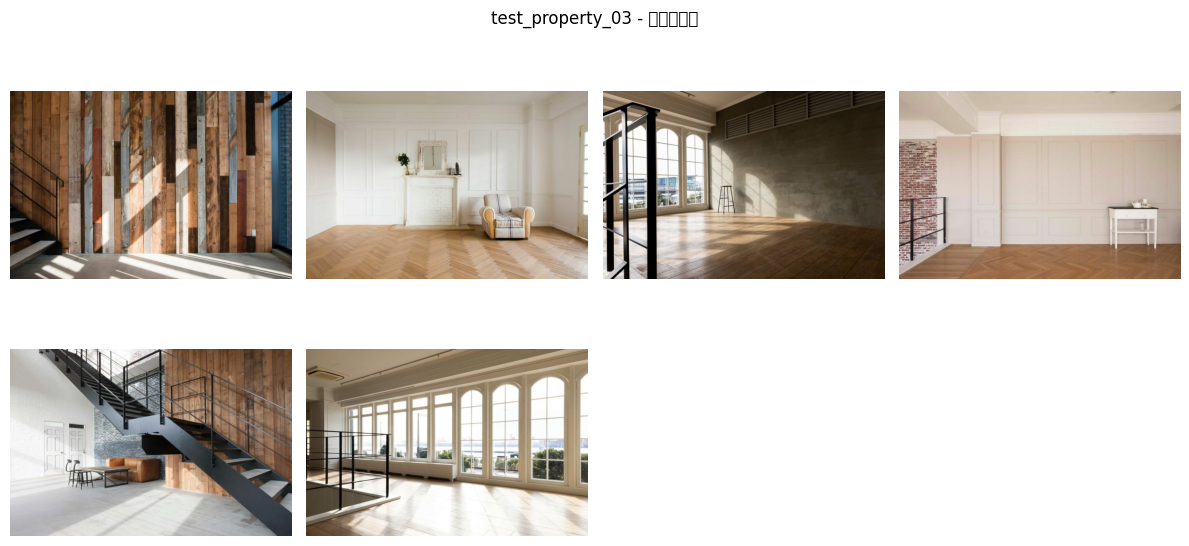

  📸 13枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [4/9] 物件フォルダ: `test_property_04`

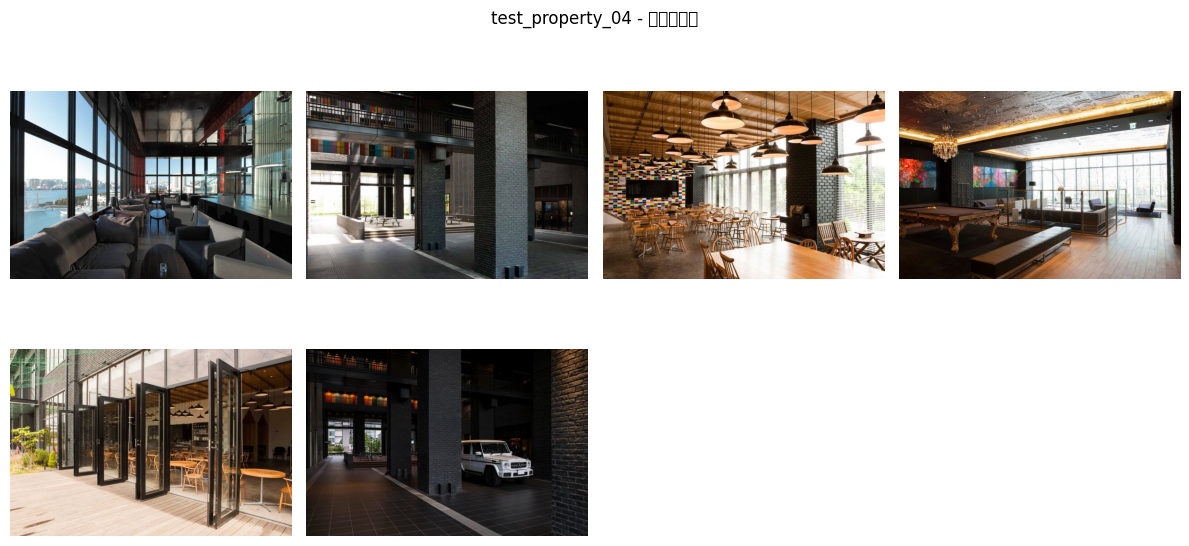

  📸 19枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [5/9] 物件フォルダ: `test_property_05`

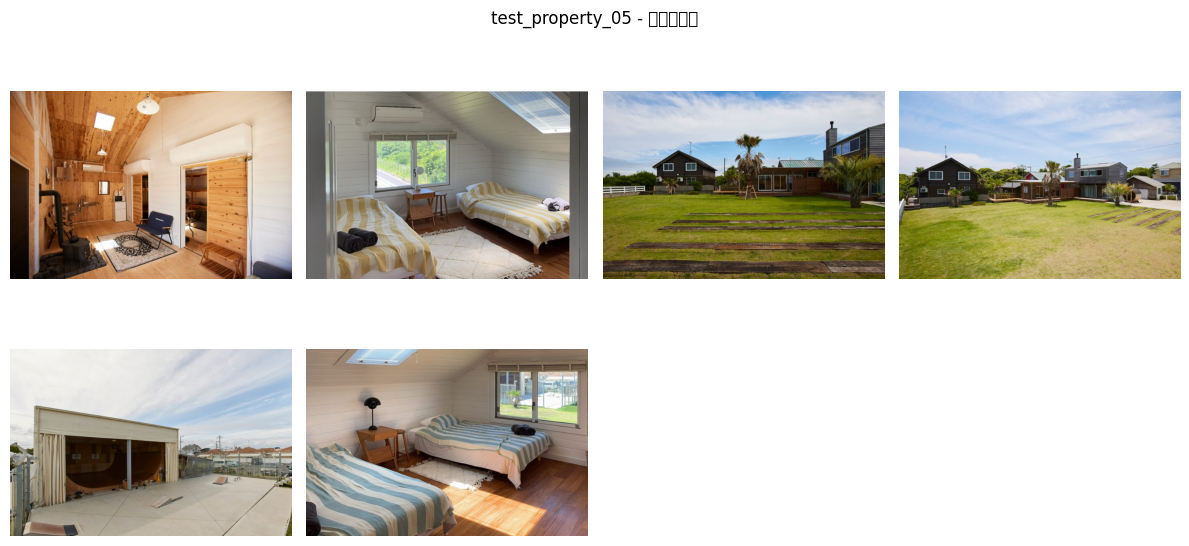

  📸 25枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [6/9] 物件フォルダ: `test_property_06`

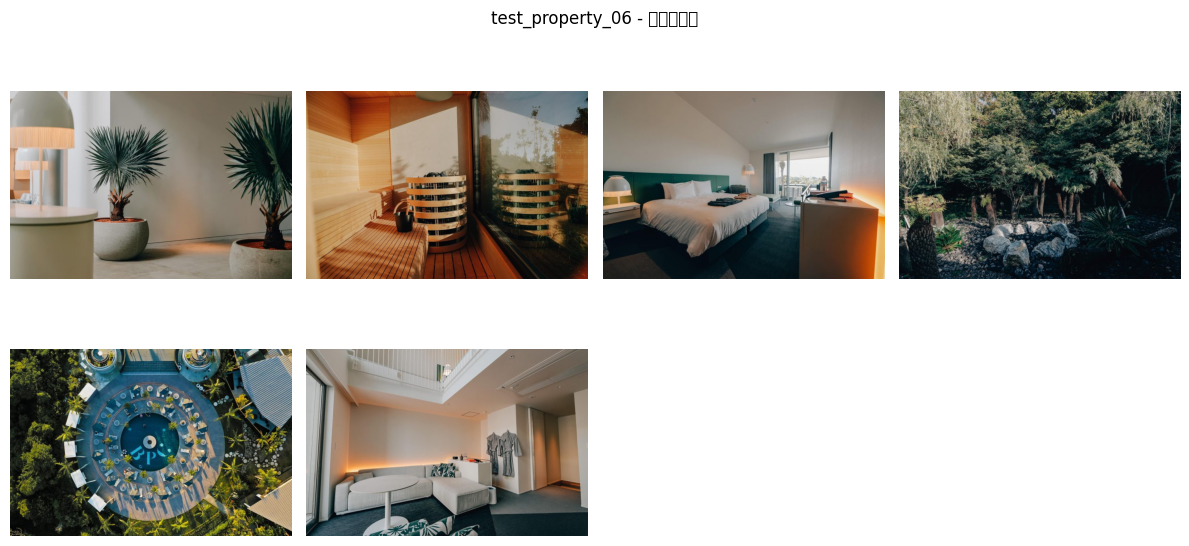

  📸 22枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [7/9] 物件フォルダ: `test_property_07`

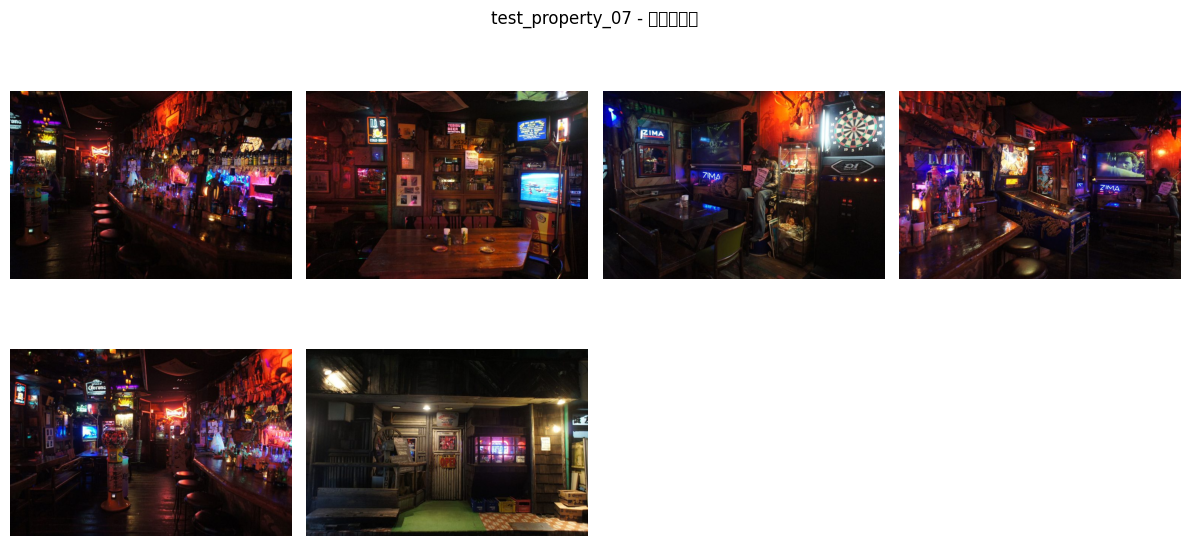

  📸 16枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [8/9] 物件フォルダ: `test_property_08`

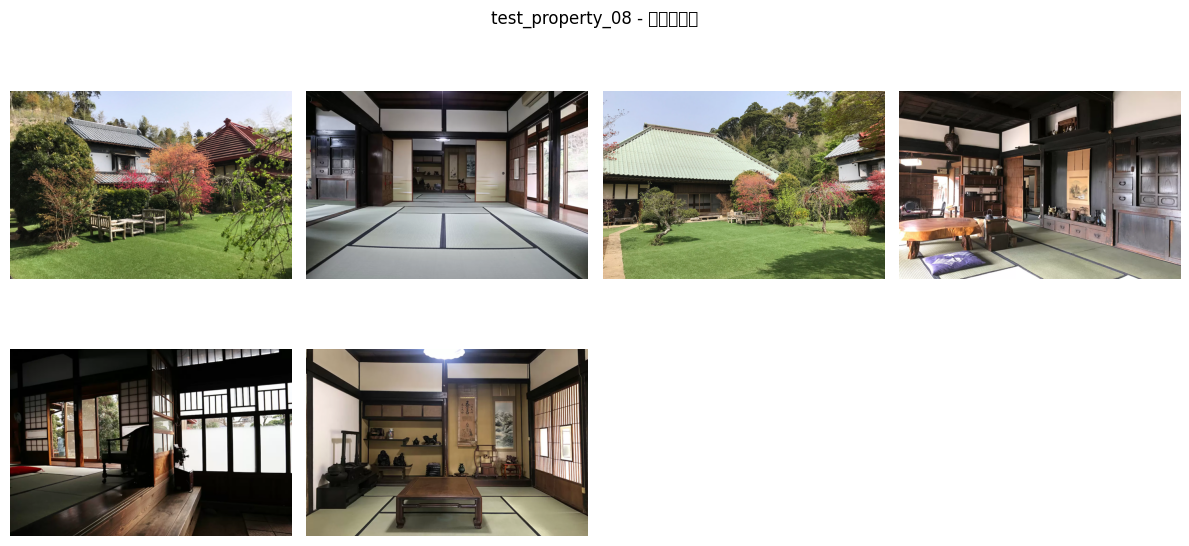

  📸 9枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## [9/9] 物件フォルダ: `test_property_09`

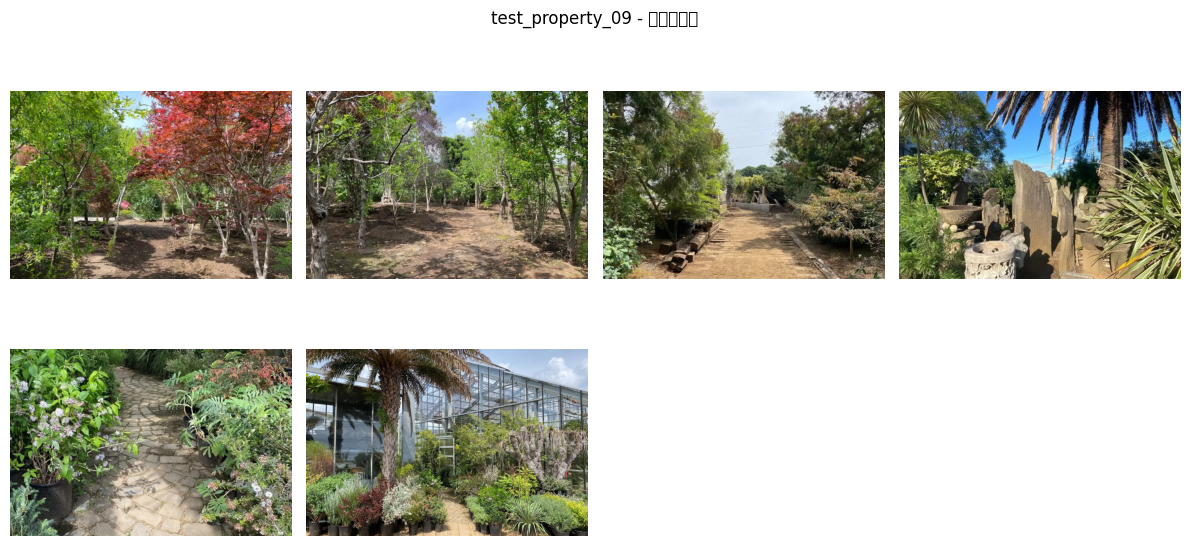

  📸 9枚の画像を分析中...


### 分類結果（JSON）

<IPython.core.display.JSON object>

## 📊 全体サマリー（DataFrame）

大分類      小項目                                               印象タグ  \
0  ハウススタジオ      一軒家  [落ち着き(calm), 温かみ(warm), 自然光豊富(abundant_dayligh...   
1  ハウススタジオ      一軒家  [落ち着き(calm), 温かみ(warm), 自然光豊富(abundant_dayligh...   
2  ハウススタジオ      一軒家                       [自然光豊富, クリーン, 温かみ, 木質感, 白基調]   
3      その他  ハウススタジオ  [クール(cool), 高級感(luxury), 無機質/インダストリアル(industri...   
4  ハウススタジオ      一軒家               [ナチュラル/オーガニック, 温かみ, 自然光豊富, 白基調, 木質感]   
5      その他  リゾートホテル                      [クリーン, クール, 高級感, 自然光豊富, ミニマル]   
6      飲食店      BAR           [ノスタルジック/レトロ, 低照度/ダーク, 暖色照明, 生活感あり, 温かみ]   
7  ハウススタジオ   和風,一軒家  [落ち着き(calm), 温かみ(warm), ノスタルジック/レトロ(nostalgic)...   
8      その他      その他  [ナチュラル/オーガニック(natural), 自然光豊富(abundant_dayligh...   

                                            オブジェクトタグ  \
0  [大窓/連窓(ribbon_windows), 梁/柱が見える(exposed_beams_...   
1  [大窓/連窓(ribbon_windows), 梁/柱が見える(exposed_beams_...   
2  [大窓/連窓, 階段（直/螺旋/外階段）, 梁/柱が見える, 吹き抜け, 造作・設備, キッ...   
3  [大開口/全面ガラス(large_opening_glass), 吹き抜け(atrium_v...   
4  [ウッドデッキ/芝/庭園, 大窓/連窓, キッチン（アイランド/業務用）, 梁/柱が見える,...   
5  [プール, サウナ, バルコニー_テラス, 大窓_連窓, ベッド, ラウンジチェア_アームチ...   
6  [カウンター/バー, ネオン/看板光, テレビ, テーブル, 椅子, 棚, ゲーム機, 小道...   
7  [畳/和素材(tatami_washi), 梁/柱が見える(exposed_beams_co...   
8  [ウッドデッキ/芝/庭園(deck_lawn_garden), 大開口/全面ガラス(larg...   

                         判定理由             フォルダ名  画像枚数  
0    複数部屋と異なる内装、家具から撮影スタジオと判断  test_property_01    30  
1    家具配置、自然光、内装から撮影スタジオ用途と判断  test_property_02    25  
2          多様な部屋と自然光、撮影に適した内装  test_property_03    13  
3     多様な空間と高級感ある内装、撮影スタジオ利用可  test_property_04    19  
4      広大な敷地と複数の建物、室内外の自然素材使用  test_property_05    25  
5  プール、サウナ、客室などから高級リゾートホテルと判断  test_property_06    22  
6  カウンター、テーブル、椅子、酒類などからBARと判断  test_property_07    16  
7         古民家を改修した、和風ハウススタジオ。  test_property_08     9  
8              植物園併設のハウススタジオ風  test_property_09     9

**✅ 保存しました**  
- JSON: `classification_results_20250829_154718.json`  
- CSV: `classification_results_20250829_154718.csv`

In [26]:
run_notebook_demo(base_folder="studio_photos", max_images_preview=6)